In [1]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.metrics import euclidean_distances
from sklearn.utils import check_random_state, check_array, check_symmetric
#from sklearn.externals.joblib import Parallel, delayed, effective_n_jobs
from sklearn.isotonic import IsotonicRegression

def NMDSfunc(dissimilarities, n_dimensions=2, max_iter=300, verbose=False, eps=1e-3, random_state=None):
    '''
    dissimilarities: matrix
    eps: used for convergence
    '''
    dissimilarities = check_symmetric(dissimilarities, raise_exception=True)
    n_samples = dissimilarities.shape[0]
    random_state = check_random_state(random_state)

    sim_flat = ((1 - np.tri(n_samples)) * dissimilarities).ravel()
    sim_flat_w = sim_flat[sim_flat != 0]
    #Random initial configuration
    X = random_state.rand(n_samples * n_dimensions)
    X = X.reshape((n_samples, n_dimensions))

    old_stress = None
    ir = IsotonicRegression()
    for it in range(max_iter):
        # Compute distance and monotonic regression
        dis = euclidean_distances(X)
        dis_flat = dis.ravel()
        dis_flat_w = dis_flat[sim_flat != 0]

        # Find disparities using monotonic regression
        disparities_flat = ir.fit_transform(sim_flat_w, dis_flat_w)
        disparities = dis_flat.copy()
        disparities[sim_flat != 0] = disparities_flat
        disparities = disparities.reshape((n_samples, n_samples))
        disparities *= np.sqrt((n_samples * (n_samples - 1) / 2) / (disparities ** 2).sum())
        # Compute stress
        stress = ((dis.ravel() - disparities.ravel()) ** 2).sum() / 2

        # Update X using the Guttman transform
        dis[dis == 0] = 1e-5
        ratio = disparities / dis
        B = - ratio
        B[np.arange(len(B)), np.arange(len(B))] += ratio.sum(axis=1)
        X = 1. / n_samples * np.dot(B, X)

        dis = np.sqrt((X ** 2).sum(axis=1)).sum()
        if verbose:
            print('iteration: %d, stress %s' % (it, stress))
        if old_stress is not None:
            if(old_stress - stress / dis) < eps:
                if verbose:
                    print('convergence: breaking at iteration %d with stress %s' % (it,stress))
                break
        old_stress = stress / dis

    return X, stress, it + 1


def NMDS(dissimilarities, n_dimensions=2, n_init=4,
            max_iter=300, verbose=False, eps=1e-3, random_state=None):
    """
    Multiple(n_init) iterations to find the best stress at a particular dimension
    """
    dissimilarities = check_array(dissimilarities)
    random_state = check_random_state(random_state)

    best_pos, best_stress = None, None
    for it in range(n_init):
        pos, stress, n_iter_ = NMDSfunc(dissimilarities, n_dimensions=n_dimensions, max_iter=max_iter, verbose=verbose,
                eps=eps, random_state=random_state)
        #print(pos)
        print(stress)
        if best_stress is None or stress < best_stress:
            best_stress = stress
            best_pos = pos.copy()
            best_iter = n_iter_
            
    return best_pos, best_stress, best_iter


class MDS():
    def __init__(self, n_dimensions=2,  n_init=8,
                 max_iter=300, verbose=False, eps=1e-3,
                 random_state=None):
        self.n_dimensions = n_dimensions
        self.n_init = n_init
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose
        self.random_state = random_state

    def fit(self, X, y=None):
      
        #self.fit_transform(X)
        X = check_array(X)
        self.dissimilarity_matrix_ = X
        
        self.embedding, self.stress, self.n_iter = NMDS(self.dissimilarity_matrix_,
            n_dimensions=self.n_dimensions, n_init=self.n_init,
            max_iter=self.max_iter, verbose=self.verbose,
            eps=self.eps, random_state=self.random_state)
        
        return self

In [2]:
sim = np.array([[0, 5, 3, 4],
                [5, 0, 2, 2],
                [3, 2, 0, 1],
                [4, 2, 1, 0]])
mds_clf = MDS()
a = mds_clf.fit(sim)

0.0408453693771
0.0310810106281
0.00355883981029
0.069898072332
0.0182663580095
0.00327010262335
0.0431592526525
0.120059400225


In [12]:
a.stress

0.0062211894789532228

In [13]:
a.embedding

array([[-0.38360999, -0.63217406],
       [ 0.0510776 ,  0.2157904 ],
       [ 0.13745651,  0.13803771],
       [ 0.19471238,  0.29098158]])

In [3]:
sim2 = np.array(
                [[0, 1, 4, 5, 3, 4, 2, 8, 8, 5, 7, 1],
                [1, 0, 3, 8, 2, 6, 2, 7, 8, 8, 7, 2],
                [4, 3, 0, 7, 2, 3, 3, 7, 8, 6, 4, 3],
                [5, 8, 7, 0, 8, 9, 3, 8, 2, 2, 9, 5],
                [3, 2, 2, 8, 0, 6, 4, 8, 9, 6, 4, 2],
                [4, 6, 3, 9, 6, 0, 1, 3, 9, 8, 5, 3],
                [2, 2, 3, 3, 4, 1, 0, 4, 3, 6, 7, 1],
                [8, 7, 7, 8, 8, 3, 4, 0, 9, 6, 9, 5],
                [8, 8, 8, 2, 9, 9, 3, 9, 0, 4, 9, 9],
                [5, 8, 6, 2, 6, 8, 6, 6, 4, 0, 4, 3],
                [7, 7, 4, 9, 4, 5, 7, 9, 9, 4, 0, 6],
                [1, 2, 3, 5, 2, 3, 1, 5, 9, 3, 6, 0]])
mds_2 = MDS(n_dimensions=4)
b = mds_2.fit(sim2)


0.720553608212
0.430344995354
0.764255783726
0.746763159659
0.910564865908
0.568655475868
0.829905584784
0.869387937781


In [15]:
b.stress

0.13095140545162059

In [4]:
output = []
for i in range(1,15):
    model = MDS(n_dimensions=i)
    b = model.fit(sim2)
    output.append(b)


5.09651705897
4.94265865301
5.52136965527
4.34934864879
4.4547983348
4.54166685757
5.54305086821
4.39385443103
1.5313930249
2.01853363716
2.36365172799
2.1647223279
2.55018649014
2.454146547
2.22859850747
2.26642806248
1.40404939292
1.1979499538
1.49693810114
1.28968322714
0.70730471666
1.44418563693
1.10118424056
0.972076529309
0.817771941858
0.888547934443
0.544559029843
0.854515550056
0.742922652191
0.770700621477
0.721157827649
0.689896934039
0.336937188174
0.47309274404
0.492764259368
0.536580401351
0.560288671143
0.579188065471
0.571831091408
0.512178307681
0.353970107862
0.0932926705697
0.396440579462
0.50126839593
0.399388489818
0.345943781176
0.469811409614
0.443252640301
0.313615244452
0.275330622889
0.248004122091
0.307857275675
0.325878042535
0.290658094363
0.250525149352
0.355903696711
0.229588101516
0.250105180397
0.208621420337
0.207116695064
0.338131662352
0.214076765069
0.255914459697
0.289384158713
0.149782414227
0.170011449097
0.201356732426
0.179547225807
0.17553629

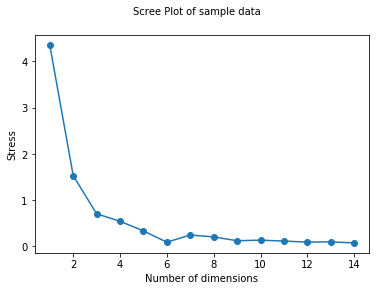

In [6]:
val = []
for i in range(0,14):  
    val.append(output[i].stress)
    
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
 
# data
df=pd.DataFrame({'x': range(1,15), 'y': val })
 
# plot
fig = plt.figure()
plt.plot( 'x', 'y', data=df, linestyle='-', marker='o')
fig.suptitle('Scree Plot of sample data', fontsize = 10)
plt.xlabel('Number of dimensions',fontsize = 10)
plt.ylabel('Stress',fontsize = 10)
plt.show()

def test():
    
    pass


In [20]:
import pandas as pd
a = pd.read_csv('SimilarityMatrixv2.csv')
dsim = (7- a.drop(a.columns[0], axis = 1)).values

#nmds = MDS(n_dimensions=40)
#ans = mds_2.fit(dsim)

output = []
for i in range(1,45):
    nmds = MDS(n_dimensions=i)
    ans = nmds.fit(dsim)
    output.append(ans)

81.9251736067
76.8828882051
80.8819500045
78.0003276162
77.8446436553
79.1606924197
77.2771514966
78.0307331612
41.6947592756
42.4675500207
40.6325767139
40.8895183653
40.8455584955
42.0909158016
41.4640999208
41.6989452001
27.4574352895
27.8502977991
26.7873870591
28.0524499132
28.4301014595
26.4856814755
25.0169464286
27.9687640755
18.314049007
18.3274431645
18.0197100269
18.1801078774
17.5589577681
19.1374909091
18.8966576453
18.4314718967
14.1073004547
14.2673383857
13.1754406701
13.0653061053
13.1978401636
14.3434123726
13.3433939528
13.0977696111
11.0155779049
11.0652056711
11.5782600762
10.8812563631
10.5599052951
10.6272512556
11.342068047
11.088684012
9.31544617495
8.86149788328
9.07071577223
8.79506061006
8.647397883
8.29568943797
8.55862166728
8.79870465442
7.34965017864
7.24026244605
7.63340666194
7.43527458601
7.24901642319
7.75662702561
7.71041984739
7.75935223313
6.75088729067
6.34414707884
6.52581731127
6.60542807289
6.56272901615
6.37630687756
6.38576674811
6.148748609

In [19]:
#ans.stress

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:3363: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


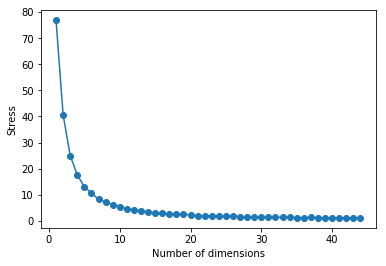

In [21]:
val = []
for i in range(0,44):  
    val.append(output[i].stress)
    
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
 
# data
df=pd.DataFrame({'x': range(1,45), 'y': val })
 
# plot
plt.plot( 'x', 'y', data=df, linestyle='-', marker='o')
fig.suptitle('Scree Plot of sample data', fontsize = 10)
plt.xlabel('Number of dimensions',fontsize = 10)
plt.ylabel('Stress',fontsize = 10)
plt.show()

In [9]:
dsim

array([[ 0.        ,  4.        ,  4.33333333, ...,  4.33333333,
         4.33333333,  5.        ],
       [ 4.        ,  0.        ,  3.75      , ...,  3.75      ,
         1.        ,  4.5       ],
       [ 4.33333333,  3.75      ,  0.        , ...,  2.        ,
         0.        ,  6.        ],
       ..., 
       [ 4.33333333,  3.75      ,  2.        , ...,  0.        ,
         1.        ,  4.66666667],
       [ 4.33333333,  1.        ,  0.        , ...,  1.        ,
         0.        ,  4.        ],
       [ 5.        ,  4.5       ,  6.        , ...,  4.66666667,
         4.        ,  0.        ]])

In [10]:
nmds2 = MDS(n_dimensions=2)
ans2 = nmds2.fit(dsim)

'''
from sklearn.decomposition import PCA
clf = PCA(n_components=2)
npos = clf.fit_transform(ans2.embedding)
'''


41.5362795535
42.8649668931
42.6278480317
41.0966777858
40.57787948
41.7876838903
41.7439724266
42.0572269572


'\nfrom sklearn.decomposition import PCA\nclf = PCA(n_components=2)\nnpos = clf.fit_transform(ans2.embedding)\n'

In [11]:
npos = ans2.embedding
npos

array([[-0.1352606 , -0.453928  ],
       [-0.03964869,  0.03010107],
       [ 0.29199928,  0.03962491],
       [-0.38533503, -0.07288136],
       [-0.23678554,  0.27854705],
       [-0.16641767, -0.01535537],
       [-0.28803245, -0.0889327 ],
       [ 0.3035429 , -0.22764595],
       [ 0.03979357, -0.06069224],
       [-0.0093365 ,  0.25495439],
       [ 0.13603346,  0.35382994],
       [-0.35698918, -0.32473211],
       [ 0.23813676, -0.3022548 ],
       [ 0.26650204,  0.3132126 ],
       [ 0.40333642, -0.16709191],
       [-0.47585909,  0.12653044],
       [-0.43422171, -0.17273326],
       [-0.35299237, -0.28995266],
       [-0.00384562, -0.38768677],
       [-0.21398669, -0.24181753],
       [ 0.33313735, -0.41109279],
       [-0.10608   , -0.30201236],
       [-0.28077152, -0.35638656],
       [ 0.08438102,  0.45066962],
       [ 0.45583056, -0.40010967],
       [ 0.49621315, -0.30810546],
       [-0.530762  , -0.02555824],
       [-0.10036207,  0.33189481],
       [-0.21261744,

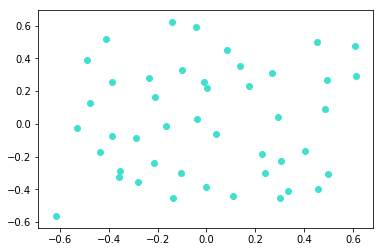

In [12]:
from matplotlib import pyplot as plt
plt.scatter(npos[:, 0], npos[:, 1], color='turquoise',  label='NMDS')
plt.show()

In [3]:
## labels for pairs
labels_pairs = ['ac', 'aa', 'ar', 'at', 'bh', 'buh', 'de', 'dro', 'dra', 
                'dc', 'et', 'fb', 'frc', 'fuc', 'gat', 'gd', 'ge' ,'gs',
                'grt', 'hd', 'hs', 'im', 'ms' , 'mc', 'mt', 'pa', 'pb',
                'ps', 'rs', 'rp', 'rv', 'rd', 'sk', 'se', 'ss', 'st', 'tl',
                'tt', 'te', 'tm', 'vr', 'wr', 'wd', 'wm', 'wl']
len(set(labels_pairs))

45

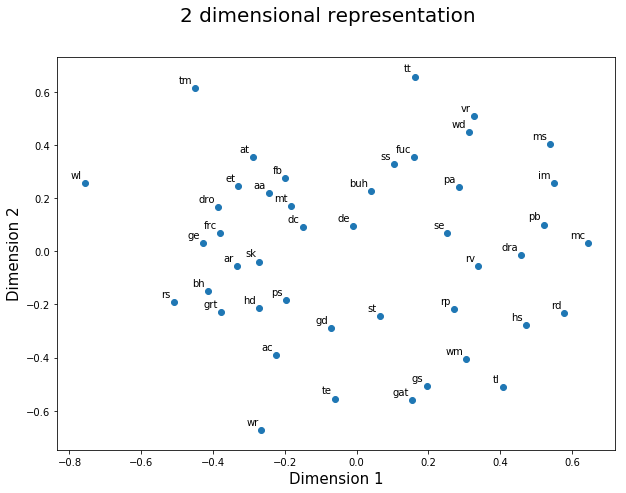

In [25]:
fig = plt.figure(figsize=(10, 7))
fig.suptitle('2 dimensional representation', fontsize = 20)
plt.xlabel('Dimension 1',fontsize = 15)
plt.ylabel('Dimension 2',fontsize = 15)
plt.subplots_adjust(bottom=0.1)  
plt.scatter(npos[:, 0], npos[:, 1], label='True Position')

for label, x, y in zip(labels_pairs, npos[:, 0], npos[:, 1]):  
    plt.annotate(label, xy=(x, y), xytext=(-3, 3), textcoords='offset points', ha='right', va='bottom')
plt.show()  

80.5439700386
84.6301717776
82.0718679441
80.8162568411
81.7885537118
80.9953401565
81.8558314879
85.4197466275
43.7891381028
43.735974445
42.7364786051
45.3942725629
42.265003388
43.5851544422
43.4722119538
42.604232457
26.6694007746
28.2862310881
27.9569850806
28.1639353968
27.4341395594
28.2059501907
26.5340374997
29.177649064
19.5239646717
18.1018784114
18.9818304868
20.4137272291
21.604355983
18.4442688883
19.7263409992
18.927853337
14.9190770029
14.7102206273
13.6418091696
13.5396486235
14.8256078267
13.7085036264
13.6973596805
14.8394398756
11.0278748766
11.4486361192
11.3525757998
11.6625480764
12.3486110763
11.1169886968
11.9464337206
11.4412121032
9.01808662497
10.3927472579
9.37292786819
9.09802204917
9.27597817203
8.9130562181
9.56294604448
8.49653682102
7.74307034356
7.90003569338
7.83268674047
7.86957284316
7.63797450428
8.03748294401
7.47996307008
7.60595862882
6.89480044944
7.44468271337
6.55825682263
6.67621082954
7.08250478759
6.42351342039
6.44598746455
7.0966058748


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:3363: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


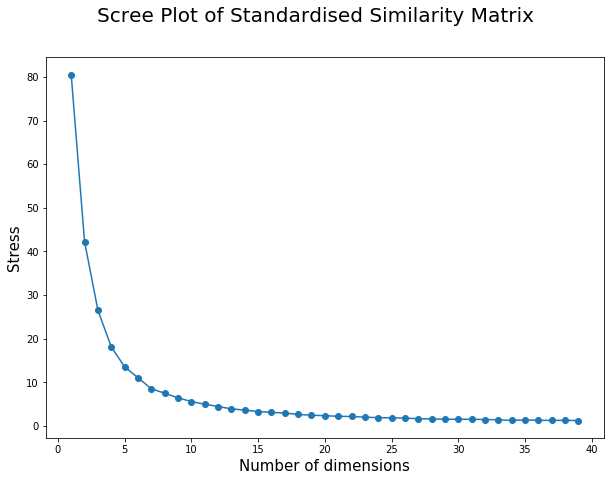

1.88324040188
1.96546039345
1.88967287365
1.8080244811
1.8976307117
1.94841834527
2.12548485607
1.79791571139


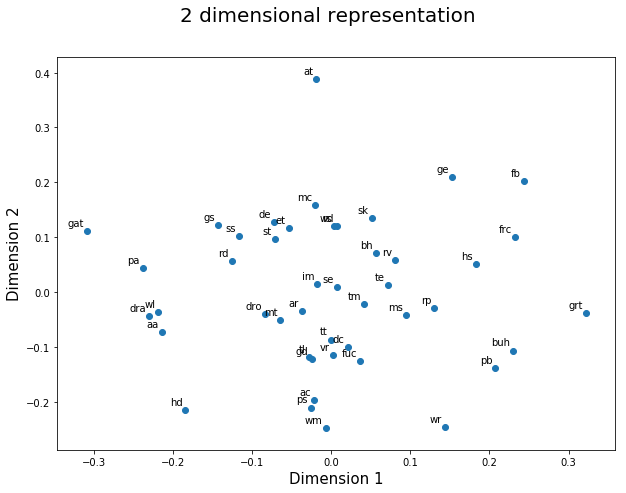

In [25]:
import pandas as pd
a = pd.read_csv('SimilarityMatrixStandardized.csv')
dsim = (2.7- a.drop(a.columns[0], axis = 1)).values

#nmds = MDS(n_dimensions=40)
#ans = mds_2.fit(dsim)

output = []
for i in range(1,40):
    nmds = MDS(n_dimensions=i)
    ans = nmds.fit(dsim)
    output.append(ans)
val = []
for i in range(0,39):  
    val.append(output[i].stress)
    
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
 
# data
df=pd.DataFrame({'x': range(1,40), 'y': val })
 
# plot
fig = plt.figure(figsize=(10, 7))
plt.plot( 'x', 'y', data=df, linestyle='-', marker='o')
fig.suptitle('Scree Plot of Standardised Similarity Matrix', fontsize = 20)
plt.xlabel('Number of dimensions',fontsize = 15)
plt.ylabel('Stress',fontsize = 15)
plt.show()

nmds2 = MDS(n_dimensions=25)
ans2 = nmds2.fit(dsim)
#npos = ans2.embedding
#npos

from sklearn.decomposition import PCA
clf = PCA(n_components=2)
npos = clf.fit_transform(ans2.embedding)

fig = plt.figure(figsize=(10, 7))
fig.suptitle('2 dimensional representation', fontsize = 20)
plt.xlabel('Dimension 1',fontsize = 15)
plt.ylabel('Dimension 2',fontsize = 15)
plt.subplots_adjust(bottom=0.1)  
plt.scatter(npos[:, 0], npos[:, 1], label='True Position')

for label, x, y in zip(labels_pairs, npos[:, 0], npos[:, 1]):  
    plt.annotate(label, xy=(x, y), xytext=(-3, 3), textcoords='offset points', ha='right', va='bottom')
plt.show()  

1.34442853441
1.19330900473
1.16570491032
1.3330406865
1.18488655413
1.32531821683
1.27366165239
1.2957184843


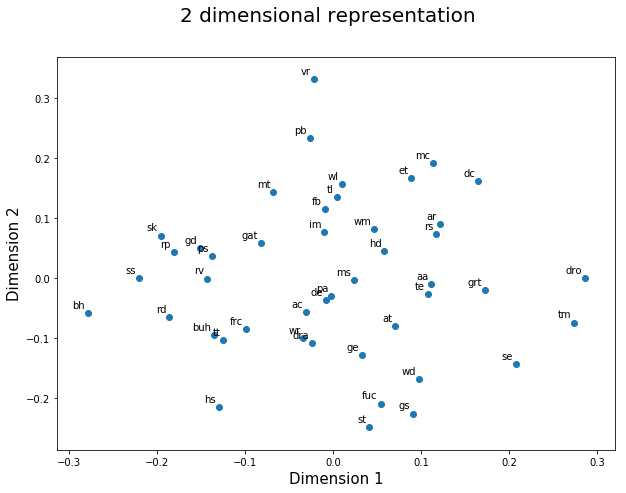

In [5]:
nmds2 = MDS(n_dimensions=40)
ans2 = nmds2.fit(dsim)
#npos = ans2.embedding
#npos

from sklearn.decomposition import PCA
clf = PCA(n_components=2)
npos = clf.fit_transform(ans2.embedding)

fig = plt.figure(figsize=(10, 7))
fig.suptitle('2 dimensional representation', fontsize = 20)
plt.xlabel('Dimension 1',fontsize = 15)
plt.ylabel('Dimension 2',fontsize = 15)
plt.subplots_adjust(bottom=0.1)  
plt.scatter(npos[:, 0], npos[:, 1], label='True Position')

for label, x, y in zip(labels_pairs, npos[:, 0], npos[:, 1]):  
    plt.annotate(label, xy=(x, y), xytext=(-3, 3), textcoords='offset points', ha='right', va='bottom')
plt.show() 

1.80292410207
1.91832004927
2.0201892033
1.92934605686
1.92213921768
1.87183639033
1.95359938201
1.97263726368


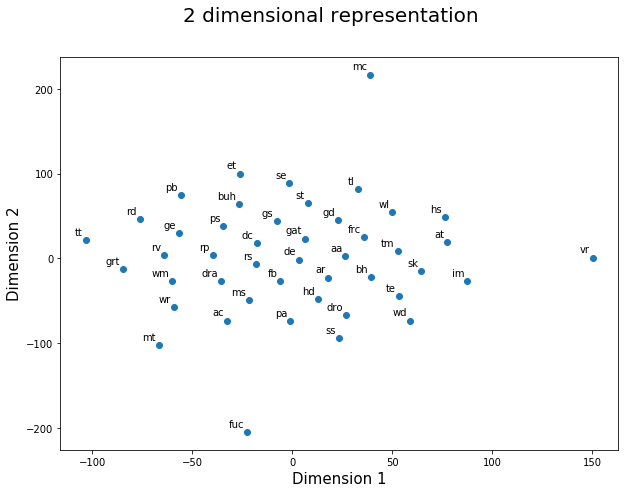

In [11]:
from sklearn.manifold import TSNE


nmdstsne = MDS(n_dimensions=25)
ans2 = nmdstsne.fit(dsim)
#npost = ans2.embedding


tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
npost = tsne.fit_transform(ans2.embedding)

fig = plt.figure(figsize=(10, 7))
fig.suptitle('2 dimensional representation', fontsize = 20)
plt.xlabel('Dimension 1',fontsize = 15)
plt.ylabel('Dimension 2',fontsize = 15)
plt.subplots_adjust(bottom=0.1)  
plt.scatter(npost[:, 0], npost[:, 1], label='True Position')

for label, x, y in zip(labels_pairs, npost[:, 0], npost[:, 1]):  
    plt.annotate(label, xy=(x, y), xytext=(-3, 3), textcoords='offset points', ha='right', va='bottom')
plt.show() 



3.52963563164
3.39414242001
3.38640802042
3.36435315454
3.38508343182
3.60264826286
3.39361840758
3.40084726697


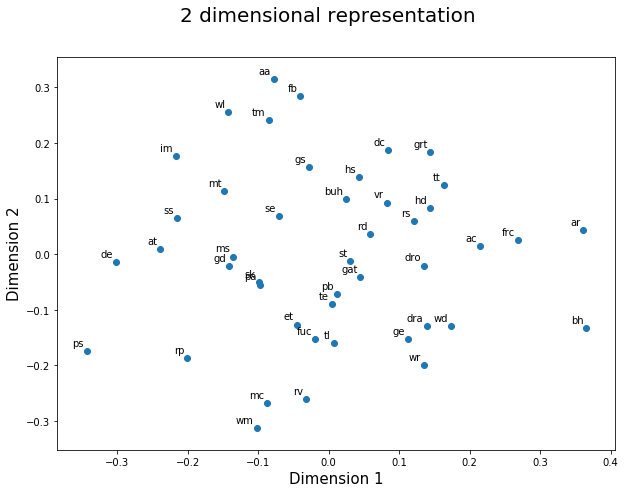

In [17]:
labels_ = ['ac', 'aa', 'ar', 'at', 'bh', 'buh', 'de', 'dro', 'dra', 
                'dc', 'et', 'fb', 'frc', 'fuc', 'gat', 'gd', 'ge' ,'gs',
                'grt', 'hd', 'hs', 'im', 'ms' , 'mc', 'mt', 'pa', 'pb',
                'ps', 'rs', 'rp', 'rv', 'rd', 'sk', 'se', 'ss', 'st', 'tl',
                'tt', 'te', 'tm', 'vr', 'wr', 'wd', 'wm', 'wl']

nmds2 = MDS(n_dimensions=15)
ans2 = nmds2.fit(dsim)
#npos = ans2.embedding
#npos

from sklearn.decomposition import PCA
clf = PCA(n_components=2)
npos = clf.fit_transform(ans2.embedding)

fig = plt.figure(figsize=(10, 7))
fig.suptitle('2 dimensional representation', fontsize = 20)
plt.xlabel('Dimension 1',fontsize = 15)
plt.ylabel('Dimension 2',fontsize = 15)
plt.subplots_adjust(bottom=0.1)  
plt.scatter(npos[:, 0], npos[:, 1], label='True Position')

for label, x, y in zip(labels_, npos[:, 0], npos[:, 1]):  
    plt.annotate(label, xy=(x, y), xytext=(-3, 3), textcoords='offset points', ha='right', va='bottom')
plt.show() 

1.90705872668
1.88084298323
2.02440005126
1.85485191319
1.89916733436
2.02290709751
1.93365172061
1.96581147565


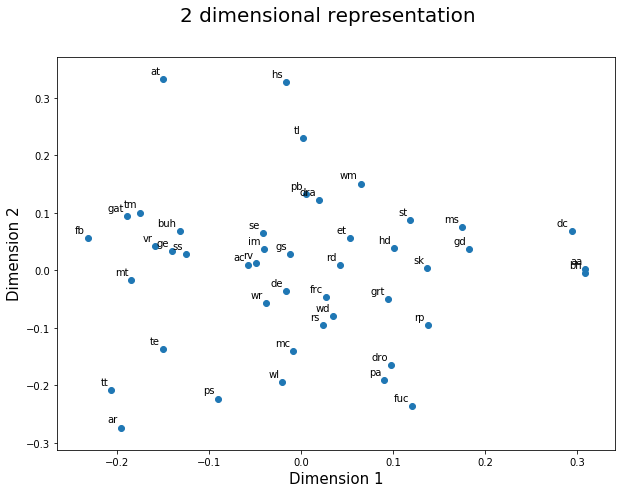

In [18]:
labels_ = ['ac', 'aa', 'ar', 'at', 'bh', 'buh', 'de', 'dro', 'dra', 
                'dc', 'et', 'fb', 'frc', 'fuc', 'gat', 'gd', 'ge' ,'gs',
                'grt', 'hd', 'hs', 'im', 'ms' , 'mc', 'mt', 'pa', 'pb',
                'ps', 'rs', 'rp', 'rv', 'rd', 'sk', 'se', 'ss', 'st', 'tl',
                'tt', 'te', 'tm', 'vr', 'wr', 'wd', 'wm', 'wl']

nmds2 = MDS(n_dimensions=25)
ans2 = nmds2.fit(dsim)
#npos = ans2.embedding
#npos

from sklearn.decomposition import PCA
clf = PCA(n_components=2)
npos = clf.fit_transform(ans2.embedding)

fig = plt.figure(figsize=(10, 7))
fig.suptitle('2 dimensional representation', fontsize = 20)
plt.xlabel('Dimension 1',fontsize = 15)
plt.ylabel('Dimension 2',fontsize = 15)
plt.subplots_adjust(bottom=0.1)  
plt.scatter(npos[:, 0], npos[:, 1], label='True Position')

for label, x, y in zip(labels_, npos[:, 0], npos[:, 1]):  
    plt.annotate(label, xy=(x, y), xytext=(-3, 3), textcoords='offset points', ha='right', va='bottom')
plt.show() 